# AVI-DYS Time Series Classification

## Import Libraries

In [1]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [2]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

save_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Confusion-Matrices\\Five-Classes"

### Create a function for predict the DIS-Scores using HIVE-COTE V2 as the classifier

Note: this version of DIS-Score DOES NOT stratify the train-test split on the dystonia measures, as these measures have only 0 or 1 observations in some categories

In [3]:
def predict_DIS(Measure, X, Y, class_names, save_path):
    """Use HIVE-COTE V2 to predict DIS-Scores from movement and skeleton data.

    Args:
        Measure (str): Dystonia-Duration, Dystonia-Amplitude, Choreoathetosis-Duration, or Choreoathetosis-Amplitude
        X (ndarray): 3D numpy array (observations, features, time-points)
        Y (DataFrame): DataFrame containing DIS-Scores as columns
        class_names (list): list of DIS-Score classes
        save_path (str): path to folder where Confusion Matrices will be saved
    """

    # Get the relevant column from the outcome measures
    y = Y[Measure].astype(str).to_numpy()

    # Split the data using a 70-30 train-test split
    if 'Dystonia' in Measure:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=None)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

    # Create the classifier
    hc2 =HIVECOTEV2(
        stc_params=None,
        drcif_params=None,
        arsenal_params=None,
        tde_params=None,
        time_limit_in_minutes=2,
        save_component_probas=False,
        verbose=1,
        n_jobs=-1,
        random_state=42,
    )

    # Fit the classifier
    hc2.fit(X_train,y_train)

    # Predict the test labels
    y_pred = hc2.predict(X_test)

    # Create the confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
    )
    disp.ax_.set_title(Measure)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, ndigits=2)
    disp.ax_.annotate(f'Accuracy = {accuracy}%',xy = (0.0, -.15),
           xycoords='axes fraction',
           ha='left',
           va="center",
           fontsize='medium',
           family='serif',
           wrap=True)

    # Save the confusion matrix
    png = str(os.path.join(save_path,f"{Measure}.png"))
    svg = str(os.path.join(save_path,f"{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')

    # Print the confusion matrix
    print('\n')
    print('Confusion Matrix')
    print(disp.confusion_matrix)

    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [4]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [5]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]


## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [6]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [7]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [8]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

#### Predict the Dystonia Duration Scores

STC  23:03:30 29/05/2023
STC train estimate  23:03:38 29/05/2023
STC weight = 0.2984587676573482
DrCIF  23:04:14 29/05/2023
DrCIF train estimate  23:04:22 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  23:04:56 29/05/2023
Arsenal train estimate  23:05:14 29/05/2023
Arsenal weight = 0.23419012939490635


c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\numba\typed\typeddict.py:33: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  d[key] = value


TDE  23:05:41 29/05/2023
TDE train estimate  23:05:41 29/05/2023
TDE weight = 0.1372779542668873


Confusion Matrix
[[ 3  0  0  1]
 [ 0  0  0  1]
 [ 0  0  0  1]
 [ 1  0  0 13]]
              precision    recall  f1-score   support

       DIS-0       0.75      0.75      0.75         4
       DIS-1       0.00      0.00      0.00         1
       DIS-3       0.00      0.00      0.00         1
       DIS-4       0.81      0.93      0.87        14

    accuracy                           0.80        20
   macro avg       0.39      0.42      0.40        20
weighted avg       0.72      0.80      0.76        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


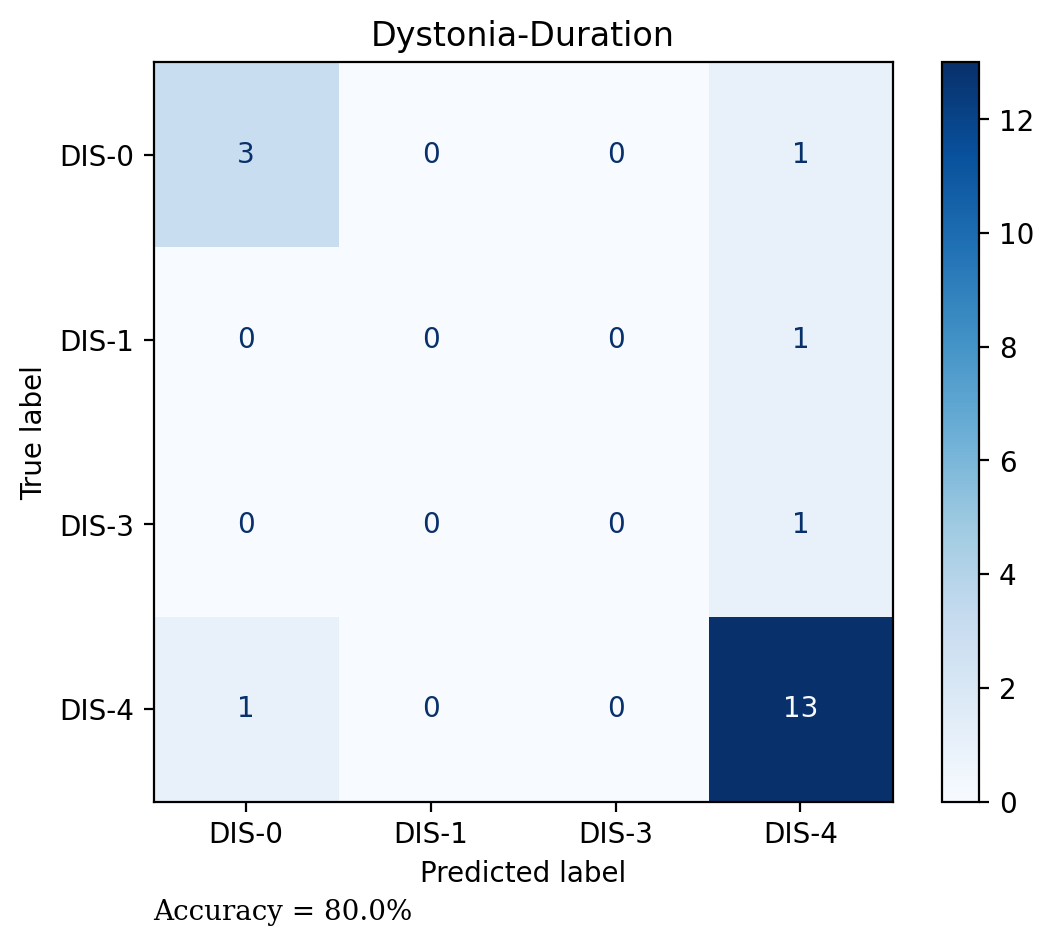

In [9]:
class_names = ['DIS-0','DIS-1','DIS-3','DIS-4']

predict_DIS('Dystonia-Duration',X,Y,class_names,save_path)

#### Predict the Dystonia Amplitude Scores

STC  23:15:00 29/05/2023
STC train estimate  23:15:40 29/05/2023
STC weight = 0.1372779542668873
DrCIF  23:16:05 29/05/2023
DrCIF train estimate  23:16:10 29/05/2023
DrCIF weight = 0.0872426217030385
Arsenal  23:16:41 29/05/2023
Arsenal train estimate  23:16:57 29/05/2023
Arsenal weight = 0.15796492472511178
TDE  23:17:18 29/05/2023
TDE train estimate  23:17:18 29/05/2023
TDE weight = 0.0740992206288571


Confusion Matrix
[[4 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 4]
 [1 0 0 0 9]]
              precision    recall  f1-score   support

       DIS-0       0.67      1.00      0.80         4
       DIS-1       0.00      0.00      0.00         1
       DIS-2       0.00      0.00      0.00         0
       DIS-3       0.00      0.00      0.00         5
       DIS-4       0.69      0.90      0.78        10

    accuracy                           0.65        20
   macro avg       0.27      0.38      0.32        20
weighted avg       0.48      0.65      0.55        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\si

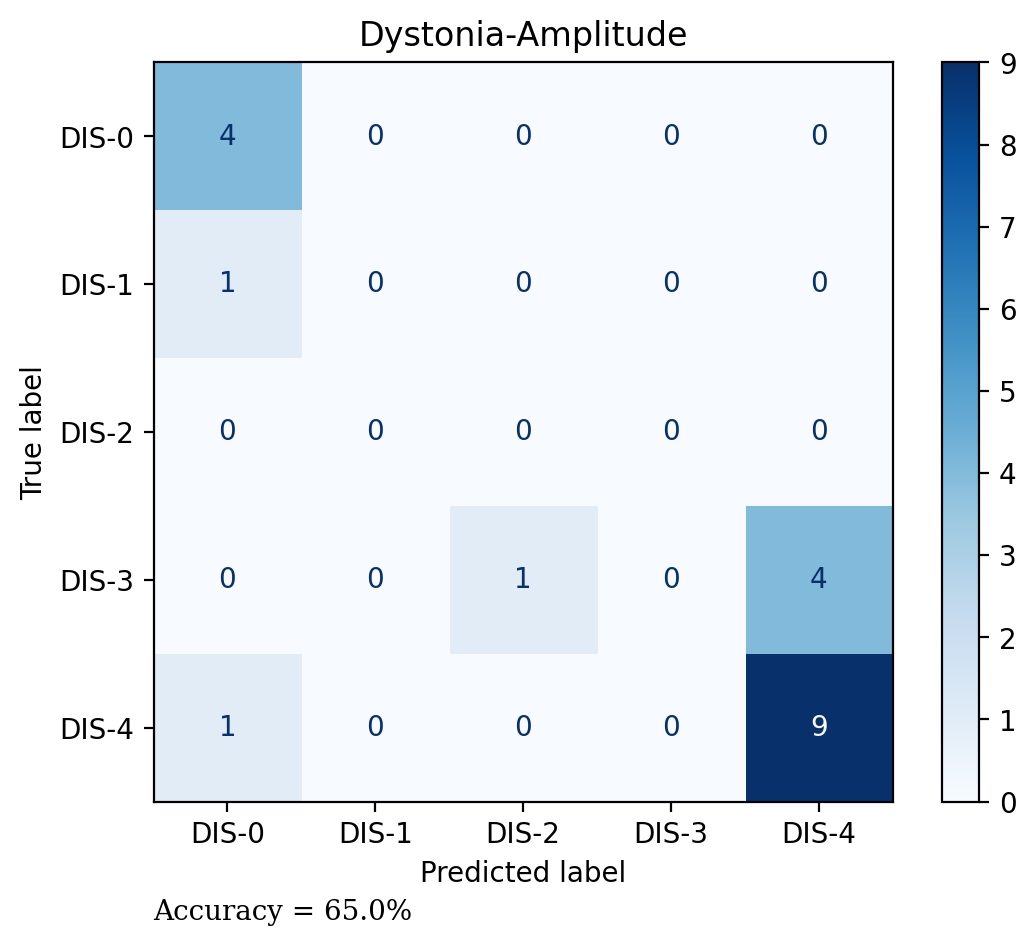

In [11]:
class_names = ['DIS-0','DIS-1', 'DIS-2','DIS-3','DIS-4']

predict_DIS('Dystonia-Amplitude',X,Y,class_names,save_path)

#### Predict the Choreoathetosis Duration Scores

STC  23:21:16 29/05/2023
STC train estimate  23:21:56 29/05/2023
STC weight = 0.003269937214346719
DrCIF  23:22:20 29/05/2023
DrCIF train estimate  23:22:26 29/05/2023
DrCIF weight = 0.014636883087181647
Arsenal  23:22:58 29/05/2023
Arsenal train estimate  23:23:15 29/05/2023
Arsenal weight = 0.0001395881947248616
TDE  23:23:35 29/05/2023
TDE train estimate  23:23:35 29/05/2023
TDE weight = 0.029106036999581905


Confusion Matrix
[[2 2 1 0 1]
 [2 3 0 0 0]
 [0 4 0 1 0]
 [1 0 0 1 0]
 [1 0 1 0 0]]
              precision    recall  f1-score   support

       DIS-0       0.33      0.33      0.33         6
       DIS-1       0.33      0.60      0.43         5
       DIS-2       0.00      0.00      0.00         5
       DIS-3       0.50      0.50      0.50         2
       DIS-4       0.00      0.00      0.00         2

    accuracy                           0.30        20
   macro avg       0.23      0.29      0.25        20
weighted avg       0.23      0.30      0.26        20



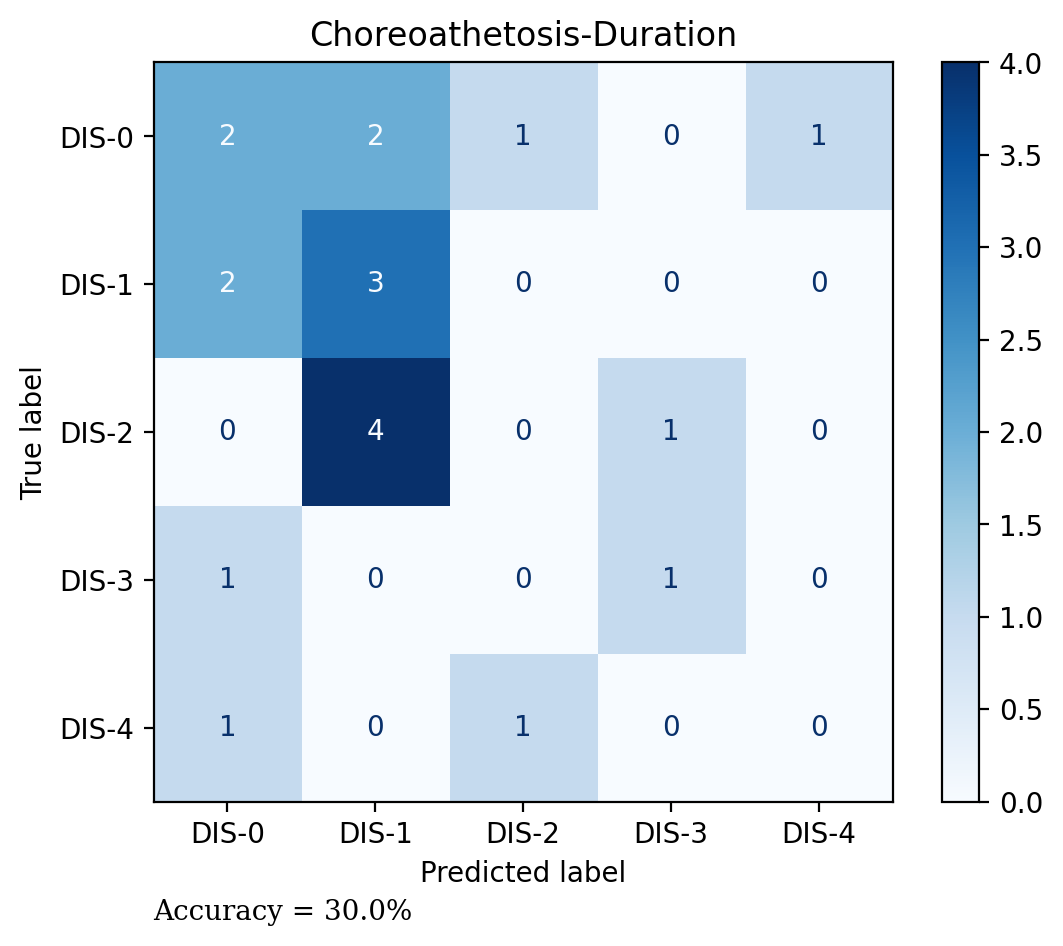

In [12]:
class_names = ['DIS-0','DIS-1','DIS-2','DIS-3','DIS-4']

predict_DIS('Choreoathetosis-Duration',X,Y,class_names,save_path)

#### Predict the Choreoathetosis Amplitude Scores

STC  23:25:22 29/05/2023
STC train estimate  23:25:58 29/05/2023
STC weight = 0.003269937214346719
DrCIF  23:26:22 29/05/2023
DrCIF train estimate  23:26:28 29/05/2023
DrCIF weight = 0.006378845487258834
Arsenal  23:26:59 29/05/2023
Arsenal train estimate  23:27:16 29/05/2023
Arsenal weight = 0.006378845487258834
TDE  23:27:37 29/05/2023
TDE train estimate  23:27:37 29/05/2023
TDE weight = 0.018653672978584262


Confusion Matrix
[[0 4 1 0 0]
 [1 3 1 0 0]
 [1 4 1 0 0]
 [0 2 1 0 0]
 [0 1 0 0 0]]
              precision    recall  f1-score   support

       DIS-0       0.00      0.00      0.00         5
       DIS-1       0.21      0.60      0.32         5
       DIS-2       0.25      0.17      0.20         6
       DIS-3       0.00      0.00      0.00         3
       DIS-4       0.00      0.00      0.00         1

    accuracy                           0.20        20
   macro avg       0.09      0.15      0.10        20
weighted avg       0.13      0.20      0.14        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


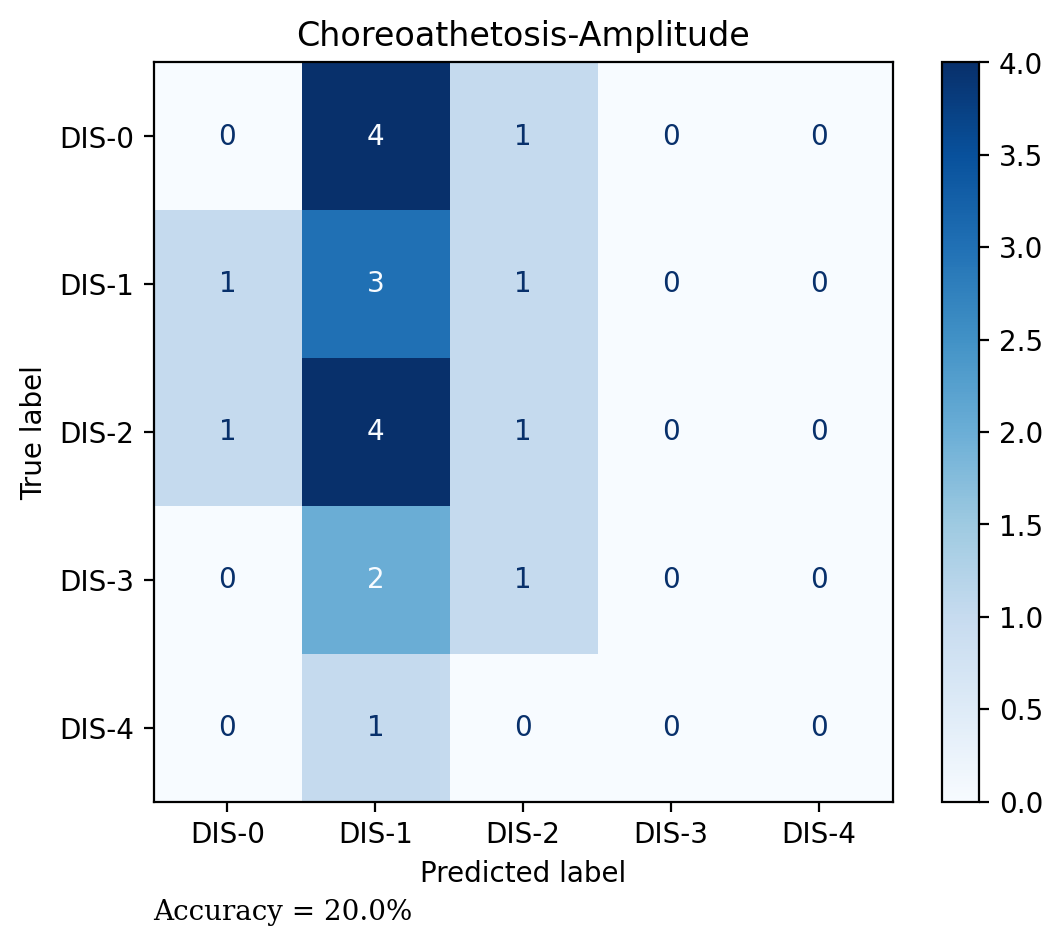

In [13]:
class_names = ['DIS-0','DIS-1','DIS-2','DIS-3','DIS-4']

predict_DIS('Choreoathetosis-Amplitude',X,Y,class_names,save_path)